In [209]:
# from comet_ml import Experiment
# experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

In [210]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.utils import np_utils 

In [211]:
import os
import fnmatch

import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

import itertools

import scipy.stats as stats

## Load Data

In [212]:
train_path = "I:\\Honours-Project\\data\\sorted\\agg\\train\\"
train_csv = "I:\\Honours-Project\\data\\sorted\\agg\\train\\ids.csv"
test_path = "I:\\Honours-Project\\data\\sorted\\agg\\test\\"
test_csv = "I:\\Honours-Project\\data\\sorted\\agg\\test\\ids.csv"

dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"

csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [213]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)
df = df[df['name'].str.contains("_flipped")]

In [214]:
df.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks,sd,num_local_peaks
268,159_flipped,2017.11.23,3600,12.20 s.tifheightmap.mat,9.024321,3211,16442.266280,0.920166,1,0.455074,5.120606,[[3.21100000e+03 1.52583000e+05 8.94101100e+06...,-0.954634,271.563492,[[ 320.08762545 -293.11866355]\r\n [-293.11866...,0,1,2.758256,5
224,119_flipped,2017.11.22,7200,35.20 s.tifheightmap.mat,6.317282,1634,6125.725518,0.727004,1,0.672428,3.748914,[[1.63400000e+03 3.82320000e+04 1.11278800e+06...,0.629859,168.811183,[[166.56046317 51.3137445 ]\r\n [ 51.3137445 ...,2,1,2.005588,1
226,120_flipped,2017.11.22,7200,35.80 s.tifheightmap.mat,4.854192,2055,5440.452402,0.946396,1,0.368544,2.647422,[[2.05500000e+03 9.37710000e+04 5.11496900e+06...,-0.886416,236.835570,[[ 292.97894613 -278.03612482]\r\n [-278.03612...,2,1,1.399912,3
259,150_flipped,2017.11.23,1800,74.00 s.tifheightmap.mat,17.317134,2318,21528.303651,0.782971,1,0.677778,9.287448,[[2.31800000e+03 8.37060000e+04 3.76076000e+06...,-1.569404,200.509668,[[ 1.23203633e+02 -2.71778206e-01]\r\n [-2.717...,0,1,5.217220,1
343,46_flipped,2017.11.17,3600,25.60 s.tifheightmap.mat,4.974612,470,1243.052519,0.888538,1,0.725309,2.644793,[[4.70000000e+02 7.36900000e+03 1.54739000e+05...,1.456527,89.941125,[[18.60479855 7.53689452]\r\n [ 7.53689452 83...,2,1,1.564867,1


### Downsample to balanced classes

In [215]:
ds_count = min(df.groupby('date').size())
ds_flow = df.groupby('date').size().idxmin()

samples = pd.concat([df[df['date']==i].sample(n=ds_count) 
                     for i in df.date.unique()],ignore_index=True)

df = samples.sample(frac=1)

print(samples.groupby('date').size())

date
2017.11.09    22
2017.11.17    22
2017.11.22    22
2017.11.23    22
dtype: int64


### Drop columns which we aren't using as features

In [216]:
def drop_cols(df):
    return df.drop(columns=['name','date','flow_rate','source','moments',
                            'inertia_tensor','euler_number','num_peaks','cluster']).as_matrix()

In [217]:
df['log_volume'] = df['volume'].apply(np.log)

x = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical  features
mat = x.drop(columns=['euler_number', 'num_peaks', 'cluster'])

x = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

### Split data into balanced test and training sets

In [218]:
x_test = pd.concat([df[df['date']==i].sample(n=2) for i in df.date.unique()],ignore_index=True)
y_test = x_test['date'].values

x_train = pd.concat([df, x_test, x_test]).drop_duplicates(keep=False)
y_train = x_train['date'].values

x_test = drop_cols(x_test)
x_train = drop_cols(x_train)

print(x_train.shape)
print(x_test.shape)

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

(80, 11)
(8, 11)


## Run Logistic Regression

In [219]:
batch_size = 1
nb_classes = 4
nb_epoch = 30

lmda = 0.001

In [220]:
input_dim = x_train.shape[1]
#input_dim = 1

In [221]:
y_train[y_train == '2017.11.09'] = 0
y_train[y_train == '2017.11.17'] = 1
y_train[y_train == '2017.11.22'] = 2
y_train[y_train == '2017.11.23'] = 3

y_test[y_test == '2017.11.09'] = 0
y_test[y_test == '2017.11.17'] = 1
y_test[y_test == '2017.11.22'] = 2
y_test[y_test == '2017.11.23'] = 3

y_train = np_utils.to_categorical(y_train, nb_classes) 
y_test = np_utils.to_categorical(y_test, nb_classes)

In [222]:
def build_logistic_model(input_dim, output_dim, lmda):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim,
                    kernel_regularizer=l2(lmda),
                    activation='softmax'))
    
    return model

def compile_model(input_dim, output_dim, lmda, optimizer):
    model = build_logistic_model(input_dim,output_dim,lmda)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [223]:
model = None
model = build_logistic_model(input_dim, nb_classes,lmda)

In [224]:
y_train.shape

(80, 4)

In [225]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 4)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [226]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 80 samples, validate on 8 samples
Epoch 1/30
80/80 [==============================] - 2s 26ms/step - loss: 1.5946 - acc: 0.2500 - val_loss: 1.4393 - val_acc: 0.3750
Epoch 2/30
80/80 [==============================] - 0s 4ms/step - loss: 1.4314 - acc: 0.3000 - val_loss: 1.2843 - val_acc: 0.3750
Epoch 3/30
80/80 [==============================] - 0s 4ms/step - loss: 1.3475 - acc: 0.3750 - val_loss: 1.2647 - val_acc: 0.5000
Epoch 4/30
80/80 [==============================] - 0s 4ms/step - loss: 1.2996 - acc: 0.4500 - val_loss: 1.2454 - val_acc: 0.5000
Epoch 5/30
80/80 [==============================] - 0s 4ms/step - loss: 1.2626 - acc: 0.4500 - val_loss: 1.2219 - val_acc: 0.5000
Epoch 6/30
80/80 [==============================] - 0s 4ms/step - loss: 1.2353 - acc: 0.4625 - val_loss: 1.2061 - val_acc: 0.5000
Epoch 7/30
80/80 [==============================] - 0s 4ms/step - loss: 1.2123 - acc: 0.4625 - val_loss: 1.1967 - val_acc: 0.5000
Epoch 8/30
80/80 [============================

In [227]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.2013959884643555
Test accuracy: 0.375


In [241]:
model.predict_proba(x_test),1

(array([[0.20833623, 0.22617595, 0.41421658, 0.1512712 ],
        [0.05304648, 0.5497235 , 0.26334792, 0.13388202],
        [0.30580944, 0.07912634, 0.5757128 , 0.03935138],
        [0.19598007, 0.23991157, 0.30125126, 0.2628571 ],
        [0.06191311, 0.5757963 , 0.15632284, 0.20596772],
        [0.23606144, 0.11572988, 0.5506102 , 0.09759849],
        [0.12604155, 0.19349779, 0.05167484, 0.62878585],
        [0.33705646, 0.0903523 , 0.12573935, 0.4468519 ]], dtype=float32), 1)

In [239]:
y_test

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

## Confusion Matrix

In [232]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

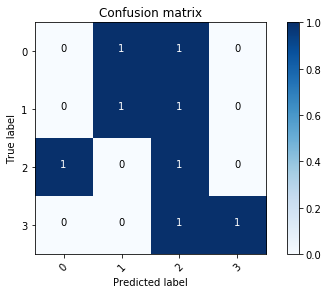

In [233]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

## LR With Cross Validation

In [234]:
batch_size = 1
nb_classes = 4
lmda = 0.01

nb_epoch = 10

In [235]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=2)
    return score[1]

In [236]:
n_folds = 10

labels = df['date'].values
data = x

labels[labels == '2017.11.09'] = 0
labels[labels == '2017.11.17'] = 1
labels[labels == '2017.11.22'] = 2
labels[labels == '2017.11.23'] = 3

one_hot = np_utils.to_categorical(labels, nb_classes) 

skf = StratifiedKFold(df['date'].values, n_folds=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

for i, (train, test) in enumerate(skf):
    print("Running Fold", i+1, "/", n_folds)
    model = None # Clearing the NN.
    model = build_logistic_model(input_dim, nb_classes, lmda)
    
    std = np.std(data[train],0)
    mean = np.mean(data[train],0)
    
    x_train = (data[train]-mean)/std
    x_test = (data[test] - mean)/std        
    
    avg_acc += train_and_evaluate_model(model, x_train, one_hot[train], x_test, one_hot[test])
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(one_hot[test],axis = 1) 
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred_classes)

Running Fold 1 / 10
Train on 76 samples, validate on 12 samples
Epoch 1/10
76/76 [==============================] - 2s 29ms/step - loss: 1.6047 - acc: 0.2763 - val_loss: 1.4658 - val_acc: 0.4167
Epoch 2/10
76/76 [==============================] - 0s 4ms/step - loss: 1.3884 - acc: 0.3289 - val_loss: 1.3951 - val_acc: 0.4167
Epoch 3/10
76/76 [==============================] - 0s 4ms/step - loss: 1.3215 - acc: 0.3684 - val_loss: 1.3725 - val_acc: 0.3333
Epoch 4/10
76/76 [==============================] - 0s 4ms/step - loss: 1.2806 - acc: 0.4342 - val_loss: 1.3583 - val_acc: 0.2500
Epoch 5/10
76/76 [==============================] - 0s 4ms/step - loss: 1.2572 - acc: 0.5132 - val_loss: 1.3640 - val_acc: 0.1667
Epoch 6/10
76/76 [==============================] - 0s 4ms/step - loss: 1.2333 - acc: 0.5263 - val_loss: 1.3494 - val_acc: 0.2500
Epoch 7/10
76/76 [==============================] - 0s 4ms/step - loss: 1.2225 - acc: 0.5395 - val_loss: 1.3429 - val_acc: 0.2500
Epoch 8/10
76/76 [=======

Running Fold 7 / 10
Train on 80 samples, validate on 8 samples
Epoch 1/10
80/80 [==============================] - 2s 28ms/step - loss: 1.5691 - acc: 0.3750 - val_loss: 1.6529 - val_acc: 0.0000e+00
Epoch 2/10
80/80 [==============================] - 0s 4ms/step - loss: 1.3663 - acc: 0.4250 - val_loss: 1.6965 - val_acc: 0.0000e+00
Epoch 3/10
80/80 [==============================] - 0s 4ms/step - loss: 1.2817 - acc: 0.4375 - val_loss: 1.7195 - val_acc: 0.0000e+00
Epoch 4/10
80/80 [==============================] - 0s 4ms/step - loss: 1.2379 - acc: 0.4750 - val_loss: 1.7394 - val_acc: 0.0000e+00
Epoch 5/10
80/80 [==============================] - 0s 4ms/step - loss: 1.2148 - acc: 0.4875 - val_loss: 1.7399 - val_acc: 0.0000e+00
Epoch 6/10
80/80 [==============================] - 0s 4ms/step - loss: 1.1948 - acc: 0.4875 - val_loss: 1.7465 - val_acc: 0.0000e+00
Epoch 7/10
80/80 [==============================] - 0s 4ms/step - loss: 1.1782 - acc: 0.5375 - val_loss: 1.7559 - val_acc: 0.0000e+0

In [237]:
print("Average Accuracy: ", avg_acc/n_folds)

Average Accuracy:  0.38749999850988387


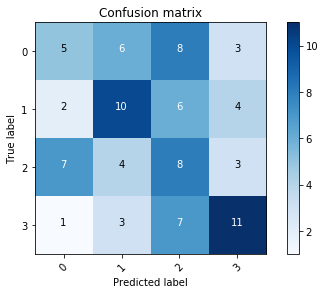

In [238]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

## Grid Search on Hyper-parameters

Note: Test dataset size is wrong?

Also: This takes a while!

In [29]:
model = KerasClassifier(build_fn=compile_model,input_dim=input_dim, output_dim=nb_classes, optimizer='sgd')

param_grid = dict(epochs=[10,20,30], batch_size=[4,8,16,32], lmda=[0.001,0.005,0.01,0.05,0.1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=2)
grid_result = grid.fit(data, one_hot)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
158/158 [==============================] - 0s 3ms/step - loss: 12.2435 - acc: 0.2405
Epoch 2/10
158/158 [==============================] - 0s 1ms/step - loss: 12.2435 - acc: 0.2405
Epoch 3/10
158/158 [==============================] - 0s 1ms/step - loss: 12.2435 - acc: 0.2405
Epoch 4/10
158/158 [==============================] - 0s 1ms/step - loss: 12.2435 - acc: 0.2405
Epoch 5/10
158/158 [==============================] - 0s 1ms/step - loss: 12.2435 - acc: 0.2405
Epoch 6/10
158/158 [==============================] - 0s 924us/step - loss: 12.2435 - acc: 0.2405
Epoch 7/10
158/158 [==============================] - 0s 905us/step - loss: 12.2435 - acc: 0.24050s - loss: 12.2164 - acc: 0.24
Epoch 8/10
158/158 [==============================] - 0s 886us/step - loss: 12.2435 - acc: 0.2405
Epoch 9/10
158/158 [==============================] - 0s 898us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


158/158 [==============================] - 0s 3ms/step - loss: 12.1404 - acc: 0.2468
Epoch 2/10
158/158 [==============================] - 0s 904us/step - loss: 12.1404 - acc: 0.2468
Epoch 3/10
158/158 [==============================] - 0s 848us/step - loss: 12.1404 - acc: 0.2468
Epoch 4/10
158/158 [==============================] - 0s 943us/step - loss: 12.1404 - acc: 0.2468
Epoch 5/10
158/158 [==============================] - 0s 898us/step - loss: 12.1404 - acc: 0.2468
Epoch 6/10
158/158 [==============================] - 0s 999us/step - loss: 12.1404 - acc: 0.2468
Epoch 7/10
158/158 [==============================] - 0s 879us/step - loss: 12.1404 - acc: 0.2468
Epoch 8/10
158/158 [==============================] - 0s 876us/step - loss: 12.1404 - acc: 0.2468
Epoch 9/10
158/158 [==============================] - 0s 915us/step - loss: 12.1404 - acc: 0.2468
Epoch 10/10
158/158 [==============================] - 0s 449us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total

159/159 [==============================] - 0s 880us/step - loss: 12.2671 - acc: 0.2390
Epoch 9/10
159/159 [==============================] - 0s 842us/step - loss: 12.2671 - acc: 0.2390
Epoch 10/10
159/159 [==============================] - 0s 515us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total=   2.1s
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
159/159 [==============================] - 1s 4ms/step - loss: 11.6600 - acc: 0.2767
Epoch 2/10
159/159 [==============================] - 0s 849us/step - loss: 11.6600 - acc: 0.2767
Epoch 3/10
159/159 [==============================] - 0s 886us/step - loss: 11.6600 - acc: 0.2767
Epoch 4/10
159/159 [==============================] - 0s 955us/step - loss: 11.6600 - acc: 0.2767
Epoch 5/10
159/159 [==============================] - 0s 842us/step - loss: 11.6600 - acc: 0.2767
Epoch 6/10
159/159 [==============================] - 0s 905us/step - loss: 11.6600 - acc: 0.2767
Epoch 7/10
159/159

158/158 [==============================] - 0s 873us/step - loss: 12.3537 - acc: 0.2342
Epoch 4/10
158/158 [==============================] - 0s 829us/step - loss: 12.3536 - acc: 0.2342
Epoch 5/10
158/158 [==============================] - 0s 873us/step - loss: 12.3535 - acc: 0.2342
Epoch 6/10
158/158 [==============================] - 0s 835us/step - loss: 12.3534 - acc: 0.2342
Epoch 7/10
158/158 [==============================] - 0s 917us/step - loss: 12.3534 - acc: 0.2342
Epoch 8/10
158/158 [==============================] - 0s 898us/step - loss: 12.3533 - acc: 0.2342
Epoch 9/10
158/158 [==============================] - 0s 848us/step - loss: 12.3532 - acc: 0.2342
Epoch 10/10
158/158 [==============================] - 0s 449us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.005, total=   2.2s
[CV] batch_size=4, epochs=10, lmda=0.005 .............................
Epoch 1/10
158/158 [==============================] - 1s 4ms/step - loss: 12.0465 - acc: 0.2532
Epoch 2/10
158/158

158/158 [==============================] - 0s 443us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.01, total=   2.5s
[CV] batch_size=4, epochs=10, lmda=0.01 ..............................
Epoch 1/10
158/158 [==============================] - 1s 5ms/step - loss: 11.9541 - acc: 0.2595
Epoch 2/10
158/158 [==============================] - 0s 886us/step - loss: 11.9539 - acc: 0.2595
Epoch 3/10
158/158 [==============================] - 0s 898us/step - loss: 11.9536 - acc: 0.2595
Epoch 4/10
158/158 [==============================] - 0s 892us/step - loss: 11.9533 - acc: 0.2595
Epoch 5/10
158/158 [==============================] - 0s 917us/step - loss: 11.9530 - acc: 0.2595
Epoch 6/10
158/158 [==============================] - 0s 987us/step - loss: 11.9527 - acc: 0.2595
Epoch 7/10
158/158 [==============================] - 0s 911us/step - loss: 11.9524 - acc: 0.2595
Epoch 8/10
158/158 [==============================] - 0s 898us/step - loss: 11.9522 - acc: 0.2595
Epoch 9/10
158/158 

KeyboardInterrupt: 

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
grid

In [ ]:
x = len(means)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, means)
plt.xticks(x, params)
plt.show()